In [23]:
from database.market import Market
from database.strategy import Strategy
from extractor.tiingo_extractor import TiingoExtractor
from preprocessor.model_preprocessor import ModelPreprocessor
from preprocessor.predictor_preprocessor import PredictorPreprocessor
from modeler.modeler import Modeler
from datetime import datetime, timedelta
from tqdm import tqdm
import pandas as pd
import pickle
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from modeler.modeler import Modeler

In [2]:
market = Market()
strat= Strategy("aggregate")
## Loading Constants

In [3]:
market.connect()
tickers = market.retrieve_data("sp500")
market.close()
years = 10
end = datetime.now()
start = datetime.now() - timedelta(days=365.25*years)

In [4]:
market.connect()
test = market.retrieve_data("dataset_regression")
market.close()

In [5]:
test

,_id,date,MMM,ABT,ABMD,ACN,ATVI,ADBE,AMD,AAP,...,WHR,WMB,WYNN,XEL,XRX,XLNX,YUM,ZBRA,ZBH,ZION
0,5f3ab6e439e39b37ded23732,2008-01-02,58.884637,21.369698,15.25,28.258395,12.740701,41.71,7.140,36.041580,...,57.013408,16.689357,67.614152,13.776541,31.159782,15.750651,21.131787,34.26,61.518433,38.460908
1,5f3ab6e439e39b37ded23733,2008-01-03,58.877518,21.239512,15.02,27.772532,12.516629,41.79,6.770,36.386751,...,56.470967,17.118485,65.326966,13.857324,30.923425,15.668616,20.836121,33.93,61.583394,37.688123
2,5f3ab6e439e39b37ded23734,2008-01-04,58.208293,21.362040,14.48,27.357198,12.476296,40.36,6.250,34.200670,...,53.987158,16.600733,65.030250,13.701973,29.761334,15.183866,20.540454,32.75,61.713316,36.006679
3,5f3ab6e439e39b37ded23735,2008-01-07,57.745532,22.016801,14.74,26.620568,12.543518,40.24,6.080,35.744350,...,54.351165,16.516773,64.424455,13.913250,29.741638,15.258443,21.020215,32.82,63.717842,36.753988
4,5f3ab6e439e39b37ded23736,2008-01-08,57.104785,22.594981,14.57,26.620568,12.337372,39.22,6.000,33.903439,...,53.280557,16.605397,64.597540,13.770327,29.190137,14.691658,20.484668,32.52,62.409331,35.463182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,5f3ab6e439e39b37ded2437e,2020-07-06,158.100000,92.970000,266.21,217.550000,78.670000,452.59,53.400,138.960000,...,133.470000,19.310000,76.700000,63.580000,15.890000,102.100000,88.510000,261.63,118.070000,32.900000
3149,5f3ab6e439e39b37ded2437f,2020-07-07,154.820000,92.460000,264.59,216.330000,78.500000,449.36,52.930,136.680000,...,133.660000,18.910000,73.370000,63.600000,15.130000,99.170000,86.860000,254.26,117.000000,31.540000
3150,5f3ab6e439e39b37ded24380,2020-07-08,154.580000,92.580000,265.64,218.890000,79.280000,457.68,53.430,136.450000,...,136.000000,18.940000,74.180000,63.770000,15.420000,99.280000,86.550000,257.21,118.920000,31.680000
3151,5f3ab6e439e39b37ded24381,2020-07-09,151.450000,93.670000,265.68,219.310000,80.640000,460.84,57.255,133.750000,...,133.170000,18.270000,71.130000,63.240000,14.630000,100.230000,86.380000,262.01,117.640000,30.440000


In [29]:
ticker = "AAPL"
m = Modeler(ticker)
data = test.copy()
data["y"] = data[ticker]
features = data.drop(["date","y","_id"],axis=1)

In [30]:
for column in tqdm(features.columns):
    for i in range(14):
        features["ticker_{}_{}".format(column,i)] = features[column].shift(i)
features = features[14:]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 436/436 [00:08<00:00, 54.08it/s]


In [31]:
for i in range(14):
    data["y_{}".format(i)] = data["y"].shift(i)
data = data[14:]

In [9]:
new_labels = []
for i in range(len(data["y"])):
    row = data.iloc[i]
    new_labels.append(row[[x for x in data.columns if "y_" in x]].values)

In [10]:
# new = []
# for column in tqdm([x for x in features.columns if "_" not in x]):
#     new_row = []
#     for i in range(1,360):
#         row = features.iloc[i]
#         new_row.append(row[[x for x in features.columns if ("ticker_" + column + "_") in x]].values)
#     new.append(new_row)

In [37]:
features

,MMM,ABT,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,...,ticker_ZION_4,ticker_ZION_5,ticker_ZION_6,ticker_ZION_7,ticker_ZION_8,ticker_ZION_9,ticker_ZION_10,ticker_ZION_11,ticker_ZION_12,ticker_ZION_13
14,54.178707,22.253977,13.27,25.915283,11.947488,34.33,7.560,32.215938,12.721784,22.964120,...,37.645663,36.252951,37.161611,37.348438,37.136134,35.539612,35.463182,36.753988,36.006679,37.688123
15,53.915289,21.904639,14.98,26.550039,11.983339,34.64,7.580,33.011748,12.742847,22.685278,...,35.700962,37.645663,36.252951,37.161611,37.348438,37.136134,35.539612,35.463182,36.753988,36.006679
16,53.758662,21.298096,15.58,26.534366,11.848896,34.84,7.150,31.851591,12.791993,22.344063,...,35.420722,35.700962,37.645663,36.252951,37.161611,37.348438,37.136134,35.539612,35.463182,36.753988
17,55.132708,21.666628,15.51,26.589222,12.086412,35.15,7.460,32.733694,13.100910,22.894409,...,36.320889,35.420722,35.700962,37.645663,36.252951,37.161611,37.348438,37.136134,35.539612,35.463182
18,55.545634,21.593690,15.05,27.067248,11.754786,35.54,7.610,33.587033,13.178140,22.832037,...,39.564887,36.320889,35.420722,35.700962,37.645663,36.252951,37.161611,37.348438,37.136134,35.539612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,158.100000,92.970000,266.21,217.550000,78.670000,452.59,53.400,138.960000,14.470000,36.020000,...,33.050000,32.290000,34.250000,33.220000,35.480000,35.740000,36.080000,36.130000,35.930000,36.970000
3149,154.820000,92.460000,264.59,216.330000,78.500000,449.36,52.930,136.680000,14.140000,34.620000,...,34.000000,33.050000,32.290000,34.250000,33.220000,35.480000,35.740000,36.080000,36.130000,35.930000
3150,154.580000,92.580000,265.64,218.890000,79.280000,457.68,53.430,136.450000,14.440000,35.400000,...,32.550000,34.000000,33.050000,32.290000,34.250000,33.220000,35.480000,35.740000,36.080000,36.130000
3151,151.450000,93.670000,265.68,219.310000,80.640000,460.84,57.255,133.750000,13.920000,33.970000,...,32.410000,32.550000,34.000000,33.050000,32.290000,34.250000,33.220000,35.480000,35.740000,36.080000


In [55]:
predictions = []
for i in tqdm(range(14)):
    results = pd.DataFrame(m.sk_model({"X":features[i:],"y":data["y"].shift(i)[i:]}))
    prediction = results.sort_values("score",ascending=False).iloc[0]["model"].predict(features[-14:])
    predictions.append(prediction[len(prediction)-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [03:34<00:00, 15.29s/it]


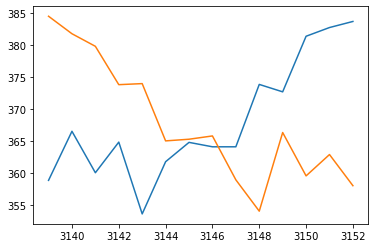

In [56]:
import matplotlib.pyplot as plt
stuff = data[-14:]
stuff["predict"] = predictions
plt.plot(stuff["y"])
plt.plot(stuff["predict"])
plt.show()

In [59]:
features[-14:]

,MMM,ABT,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,...,ticker_ZION_4,ticker_ZION_5,ticker_ZION_6,ticker_ZION_7,ticker_ZION_8,ticker_ZION_9,ticker_ZION_10,ticker_ZION_11,ticker_ZION_12,ticker_ZION_13
3139,156.69,90.34,254.66,202.60,76.12,438.64,54.760,151.60,13.98,36.46,...,36.97,36.10,34.88,33.67,36.76,39.305,40.570,38.610,37.230,35.490
3140,157.84,91.30,252.58,207.40,76.45,440.55,53.990,149.97,13.84,36.39,...,35.93,36.97,36.10,34.88,33.67,36.760,39.305,40.570,38.610,37.230
3141,152.22,87.30,241.66,201.84,75.58,431.68,52.390,143.00,13.84,35.17,...,36.13,35.93,36.97,36.10,34.88,33.670,36.760,39.305,40.570,38.610
3142,154.67,89.62,241.75,217.32,76.21,436.95,51.930,142.91,13.88,35.83,...,36.08,36.13,35.93,36.97,36.10,34.880,33.670,36.760,39.305,40.570
3143,152.52,88.71,239.27,212.47,76.40,426.92,50.100,139.99,13.75,34.68,...,35.74,36.08,36.13,35.93,36.97,36.100,34.880,33.670,36.760,39.305
3144,155.57,89.01,240.22,212.72,75.50,424.20,50.280,142.75,14.34,35.43,...,35.48,35.74,36.08,36.13,35.93,36.970,36.100,34.880,33.670,36.760
3145,155.99,91.43,241.56,214.72,75.90,435.31,52.610,142.45,14.49,36.03,...,33.22,35.48,35.74,36.08,36.13,35.930,36.970,36.100,34.880,33.670
3146,155.43,91.64,255.22,214.59,78.03,439.81,52.580,141.95,14.41,35.39,...,34.25,33.22,35.48,35.74,36.08,36.130,35.930,36.970,36.100,34.880
3147,157.04,92.23,263.84,215.72,77.51,442.95,52.340,141.84,14.48,35.26,...,32.29,34.25,33.22,35.48,35.74,36.080,36.130,35.930,36.970,36.100
3148,158.10,92.97,266.21,217.55,78.67,452.59,53.400,138.96,14.47,36.02,...,33.05,32.29,34.25,33.22,35.48,35.740,36.080,36.130,35.930,36.970


In [51]:
stuff

3150                                                  381.37
3151                                                  382.73
3152                                                  383.68
predict    [288.55704003859074, 298.02201415018567, 272.6...
Name: y, dtype: object

In [72]:
m = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=64,activation="relu"),
    tf.keras.layers.Dense(units=64,activation="relu"),
    tf.keras.layers.Dense(units=1)
])
m.compile(loss=tf.losses.MeanSquaredError(),metrics=[tf.metrics.mean_squared_error])

In [73]:
predictions = []
for i in range(14):
    m.fit(tf.stack(features[i:]),tf.stack(data["y"].shift(i)[i:]))
    prediction = m.predict(tf.stack(features))
    predictions.append(prediction[0])

98/98 [==============================] - 1s 5ms/step - loss: 381.3717 - mean_squared_error: 381.3717


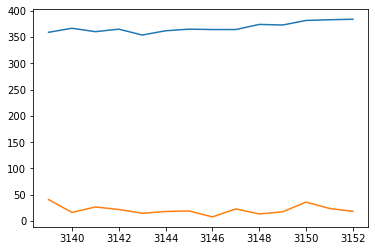

In [74]:
import matplotlib.pyplot as plt
stuff = data[-14:]
stuff["predict"] = predictions
plt.plot(stuff["y"])
plt.plot(stuff["predict"])
plt.show()

In [ ]:
days = 100
end = datetime(2020,7,1)
start = end - timedelta(days=days)
base = pd.date_range(start,end)
gap = 2
rows = []
training_days = 100
strat.connect()
for date in tqdm(base):
    if date.weekday() < 5:
        training_start = date - timedelta(days=training_days)
        training_end = date
        if date.weekday() == 4:
            prediction_date = date + timedelta(days=3)
        else:
            prediction_date = date + timedelta(days=1)
        classification = strat.retrieve_training_data("dataset_classification",training_start,prediction_date)
        classification_prediction = pd.DataFrame([classification.drop(["Date","_id"],axis=1).iloc[len(classification["Date"])-1]])
        if len(classification) > 60 and len(classification_prediction) > 0:
            for i in range(46,47):
                try:
                    ticker = tickers.iloc[i]["Symbol"]
                    if ticker in classification.columns:
                        sector = tickers.iloc[i]["GICS Sector"]
                        sub_sector = tickers.iloc[i]["GICS Sub Industry"]
                        cik = int(tickers.iloc[i]["CIK"].item())
                        classification_data = classification.copy()
                        classification_data["y"] = classification_data[ticker]
                        classification_data["y"] = classification_data["y"].shift(-gap)
                        classification_data = classification_data[:-gap]
                        mt = ModelPreprocessor(ticker)
                        rc = mt.day_trade_preprocess_classify(classification_data.copy(),ticker)
                        sp = Modeler(ticker)
                        results_rc = sp.classify_tf(rc)
                        results = pd.DataFrame([results_rc])
                        model = results.sort_values("accuracy",ascending=False).iloc[0]
                        m = model["model"]
                        mr = PredictorPreprocessor(ticker)
                        refined = mr.preprocess_classify(classification_prediction.copy())
                        cleaned = classification_prediction
                        factors = refined["X"]
                        prediction = [x[0] for x in m.predict(factors)]
                        product = market.retrieve_price_data("prices",ticker)
                        product["Date"] = [datetime.strptime(x,"%Y-%m-%d") for x in product["Date"]]
                        product = product[(product["Date"] > training_end) & (product["Date"] <= prediction_date)]
                        product["predicted"] = prediction
                        product["predicted"] = [1 if x > 0 else 0 for x in product["predicted"]]
                        product["accuracy"] = model["accuracy"]
                        product.sort_values("Date",inplace=True)
                        product = product[["Date","Adj_Close","predicted","accuracy","ticker"]].dropna()
                        strat.store_data("sim_tf",product)
                except Exception as e:
                    print(str(e))
strat.close()